# Modelling using value of R0

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [302]:
import pandas as pd, numpy as np, time
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from catboost import CatBoostRegressor
import shap
%matplotlib inline

## Read file and prepare data 

In [303]:
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL.csv')
del df['Unnamed: 0']
del df['Excess mortality P-scores, all ages']
del df['Excess mortality P-scores, all ages Prev 7 days']
del df['Excess mortality P-scores, all ages Prev 36 days']
del df['deaths']
#del df['deaths_prev_7']
del df['deaths_prev_18']
del df['deaths_prev_36']
#del df['average_deaths_2015_2019_all_ages']
del df['month']
del df['population']
del df['life_expectancy']
del df['UN Population Division (Median Age) (2017)']

Dict = {}

df['Date']=pd.to_datetime(df['Date'])
for month in df.Date.dt.month.unique():
    for country in df.Code.unique():
        
        Dict[country + '-' + str(month)]=df[(df['Code']==country) & (df['Date'].dt.month==month)]['average_deaths_2015_2019_all_ages'].describe()[7]
  

df_aux = pd.DataFrame(list(Dict.items()),columns = ['merge_code','limit']) 
df['merge_code']=df['Code'] + '-' + df['Date'].dt.month.astype(str)
df=pd.merge(df,df_aux, left_on='merge_code', right_on='merge_code')

Dict = {}

for country in df.Code.unique():
        
        Dict[country ]=df[(df['Code']==country)]['average_deaths_2015_2019_all_ages'].
  

df_aux = pd.DataFrame(list(Dict.items()),columns = ['Code','std_deaths']) 
df=pd.merge(df,df_aux, left_on='Code', right_on='Code')

In [304]:
df['limit']=5*df['average_deaths_2015_2019_all_ages']/100
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,urban_population,total_vaccinations_per_100,%youth_unemployment_total,%df_population_gr_65,"Excess mortality P-scores, all ages Prev 18 days",average_deaths_2015_2019_all_ages,deaths_prev_7,accumulated,R0,limit
0,AUS,2020-03-08,1.050000,1.722333,-0.739000,4.977667,-2.089000,7.927667,2.0,1.0,...,85.904,NaN,11.84,15.921202,6.18,3126.250,153.811500,0.000762,0.949187,156.31250
1,AUS,2020-03-15,0.761714,1.510143,-1.286000,7.697286,-0.819857,10.567714,2.0,1.0,...,85.904,NaN,11.84,15.921202,4.53,3126.250,145.995875,0.001320,0.989293,156.31250
2,AUS,2020-03-22,1.285714,3.367429,-1.081714,9.346857,0.938857,10.877857,2.0,1.0,...,85.904,NaN,11.84,15.921202,4.92,3126.250,144.432750,0.001926,1.575758,156.31250
3,AUS,2020-03-29,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,2.0,1.0,...,85.904,NaN,11.84,15.921202,4.67,3126.250,227.591000,0.002502,1.666209,156.31250
4,AUS,2020-04-05,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,2.0,1.0,...,85.904,NaN,11.84,15.921202,4.62,2564.750,311.104175,0.002969,0.932399,128.23750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.693857,-4.061286,10.183857,-36.040857,-19.755143,-28.101857,1.0,3.0,...,82.058,0.216667,8.30,16.209606,41.25,74249.625,33226.707188,0.179232,0.821006,3712.48125
2038,USA,2021-01-17,-22.775429,-3.979571,12.653143,-38.877714,-16.653143,-42.081714,1.0,3.0,...,82.058,0.686667,8.30,16.209606,41.07,74249.625,27279.312225,0.188522,0.922972,3712.48125
2039,USA,2021-01-24,-23.632714,-9.836714,14.061286,-41.020286,-15.857143,-41.714143,1.0,3.0,...,82.058,1.415000,8.30,16.209606,44.75,74249.625,25178.047837,0.198645,0.870835,3712.48125
2040,USA,2021-01-31,-23.979714,-11.387857,11.449143,-39.571429,-22.591714,-28.999857,1.0,3.0,...,82.058,2.464000,8.30,16.209606,36.74,74249.625,21925.914262,0.206956,0.830681,3712.48125


### Data fitering
* R0 is calculated as the division of deaths/deaths_prev_7
* Secondly we remove R0 values smaller than 0 and higher than 8.9 from our dataset. 
It is recorded that R0 in coronavirus ranges from 3.8 to 8.9 therefore it doesn´t make sense to include values higher than 8.9 because if any value higher than 8.9 is recorded it might be due to errors in the data.

In [305]:
df=df[~df.isin([np.inf, -np.inf]).any(1)]
df=df[(df['deaths_prev_7']>=df['limit']) & (np.abs(df['R0'])<=8.9) & (df['R0']>0)]
del df['average_deaths_2015_2019_all_ages']
del df['deaths_prev_7']
del df['limit']
df.sort_values('R0')

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,%df_population_gr_65,"Excess mortality P-scores, all ages Prev 18 days",accumulated,R0
674,EST,2020-03-22,-2.326429,-0.346857,2.775429,-0.224571,22.000000,-15.081571,0.0,0.000000,...,6.29,4.57,3147000.0,68.717,NaN,11.090000,19.991808,-5.82,0.000000,0.011152
1821,SVK,2020-08-16,1.877429,2.081714,0.979571,-11.183571,149.653000,-20.163000,2.0,2.000000,...,5.70,5.70,2027000.0,53.751,NaN,16.110001,16.172364,-6.49,0.007928,0.022010
1801,SVK,2020-03-29,-0.673571,6.183857,1.122429,0.244714,5.387714,-2.081571,2.0,1.000000,...,5.70,5.70,2027000.0,53.751,NaN,16.110001,16.172364,-1.34,0.000000,0.025176
1565,NOR,2020-09-27,-4.122571,3.877571,1.265286,-20.959286,82.857143,-19.020571,2.0,2.000000,...,17.74,3.53,5960000.0,81.871,NaN,9.880000,17.272666,-1.77,0.008865,0.030856
1875,SVN,2020-09-27,2.244857,-8.530571,-0.653000,6.285857,86.107143,-16.367286,2.0,2.000000,...,10.14,4.43,3032000.0,54.273,NaN,8.150000,20.186284,10.32,0.026486,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,ITA,2020-03-15,-0.207429,3.540857,0.173571,2.690429,18.833286,-1.105571,2.0,1.142857,...,6.73,3.14,52372000.0,70.144,NaN,29.219999,23.012137,-5.10,0.000000,4.642506
620,ESP,2020-03-22,0.938714,2.816286,-0.693714,4.142714,18.632571,-2.224571,1.0,1.000000,...,5.87,2.97,75315000.0,80.080,NaN,32.610001,19.647823,-8.98,0.000000,5.224353
121,BEL,2020-08-16,-13.081714,-11.061143,7.796000,-29.653000,131.102143,-38.020429,2.0,2.000000,...,NaN,5.58,7481000.0,97.961,NaN,14.250000,19.006566,-8.86,0.089307,6.045652
837,GBR,2020-04-05,-3.387714,8.510286,1.877429,-9.142714,7.775429,-2.714286,0.0,1.000000,...,7.78,2.46,35814000.0,83.143,NaN,11.080000,18.508696,-1.15,0.000000,7.086538


Text(0.5, 1.0, 'R0')

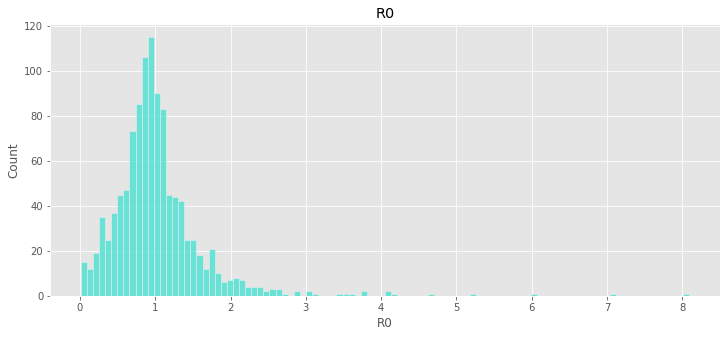

In [306]:
#Removing -inf and infinite
df=df[~df.isin([np.inf, -np.inf]).any(1)]
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes, color='turquoise');
axes.set_title('R0')

## Feature Engineering

### Approach 1: Raw data no grouping of variables or PCA Analysis

### Approach 2: Grouping variables, decreasing dimensionality and correlation
Since variables seem to have high multicollinearity will group variables with similar corellation

In [307]:
#We define bad mobility as the weighted average of mobility trends that have a positive impact on covid spread
df['bad_mobility']=(df['retail_and_recreation']*0.4+df['transit_stations']*0.2+df['grocery_and_pharmacy']*0.2
                   +df['workplaces']*0.2)
del df['retail_and_recreation']
del df['grocery_and_pharmacy']
del df['transit_stations']
del df['workplaces']

#We define good mobility as the weighted average of mobility trends that have a negative impact on covid spread
df['good_mobility']=(df['residential']*0.6+df['parks']*0.4)
del df['residential']
del df['parks']


df['tourism']=df['number_of_arrivals']*(4-df['international_travel_controls'])
df['awareness'] = df['public_information_campaigns']*0.2+df['facial_coverings']*0.8
df['work_life_closures']=df['workplace_closures']*0.7+df['school_closures']*0.3
df['government_support']=df['debt_relief']*0.5+df['income_support']*0.5
df['%df_population_gr_65']=df['%df_population_gr_65']-(df['accumulated']*df['%df_population_gr_65']/100)
df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['hospital_availability']=df['nurses_per_1000']*0.2+df['doctors_per_1000']*0.2+df['beds_per_1000']*0.6
df['youth_effect']=df['%youth_unemployment_total']*df['bad_mobility']

del df['contact_tracing']
del df['testing_policy']
del df['international_travel_controls']
del df['number_of_arrivals']
del df['public_information_campaigns']
del df['facial_coverings']
del df['workplace_closures']
del df['school_closures']
del df['debt_relief']
del df['income_support']
del df['doctors_per_1000']
del df['beds_per_1000']
del df['nurses_per_1000']
del df['%youth_unemployment_total']
del df['urban_population']
del df['%df_population_gr_65']

df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]

In [308]:
df.head()

,Code,Date,restrictions_internal_movements,close_public_transport,stay_home_requirements,restriction_gatherings,cancel_public_events,Holiday,temp,prcp,...,accumulated,bad_mobility,good_mobility,tourism,awareness,work_life_closures,government_support,hospital_availability,youth_effect,R0
3,AUS,2020-03-29,0.0,0.0,0.000000,0.000000,0.000000,0.0,21.346512,0.142010,...,0.002502,4.836771,-1.375400,8.263000e+06,0.4,0.000000,0.000000,-19.95746,57.267374,1.666209
4,AUS,2020-04-05,0.0,0.0,0.000000,0.857143,0.571429,0.0,21.176835,0.054789,...,0.002969,3.853000,-1.714343,8.263000e+06,0.4,0.000000,0.500000,-19.68556,45.619521,0.932399
5,AUS,2020-04-12,2.0,0.0,0.285714,2.285714,2.000000,0.0,20.702945,0.051898,...,0.003705,-4.383686,-2.873400,1.180429e+06,0.4,0.857143,0.642857,-34.15064,-51.902840,0.562334
6,AUS,2020-04-19,2.0,0.0,1.000000,3.571429,2.000000,0.0,21.093375,0.073336,...,0.004932,-27.187829,-3.216429,0.000000e+00,0.4,2.300000,1.500000,-60.52494,-321.903894,0.463836
8,AUS,2020-05-03,2.0,0.0,2.000000,4.000000,2.000000,2.0,19.355421,0.060733,...,0.006931,-42.469343,-3.355114,0.000000e+00,0.4,2.300000,1.500000,-29.14768,-502.837026,0.553043


### Approach 3: PCA
Since variables have a high correlation we will group variables taking use of Principal Component Analysis

In [2718]:
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['accumulated'] = df['accumulated'].fillna(0)
df['urban_population'] = df['urban_population'].fillna(df['urban_population'].mean())
df['parks'] = df['parks'].fillna(df['parks'].mean())
df['temp'] = df['temp'].fillna(df['temp'].mean())
df['prcp'] = df['prcp'].fillna(df['prcp'].mean())
df['%youth_unemployment_total'] = df['%youth_unemployment_total'].fillna(df['%youth_unemployment_total'].mean())
df['%df_population_gr_65'] = df['%df_population_gr_65'].fillna(df['%df_population_gr_65'].mean())

KeyError: 'urban_population'

In [2708]:
df.isna().sum()

Code                                                  0
Date                                                  0
retail_and_recreation                                 0
grocery_and_pharmacy                                  0
residential                                           0
transit_stations                                      0
parks                                                 0
workplaces                                            0
contact_tracing                                       0
testing_policy                                        0
international_travel_controls                         0
restrictions_internal_movements                       0
close_public_transport                                0
public_information_campaigns                          0
facial_coverings                                      0
stay_home_requirements                                0
restriction_gatherings                                0
cancel_public_events                            

In [2709]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'doctors_per_1000', 'nurses_per_1000', 'beds_per_1000',
       'number_of_arrivals', 'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', '%df_population_gr_65',
       'Excess mortality P-scores, all ages Prev 18 days', 'deaths_prev_7',
       'deaths', 'accumulated', 'R0'],
      dtype='object')

In [2710]:
features=['retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total','%df_population_gr_65',
       'Excess mortality P-scores, all ages Prev 18 days','accumulated']

# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['R0']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

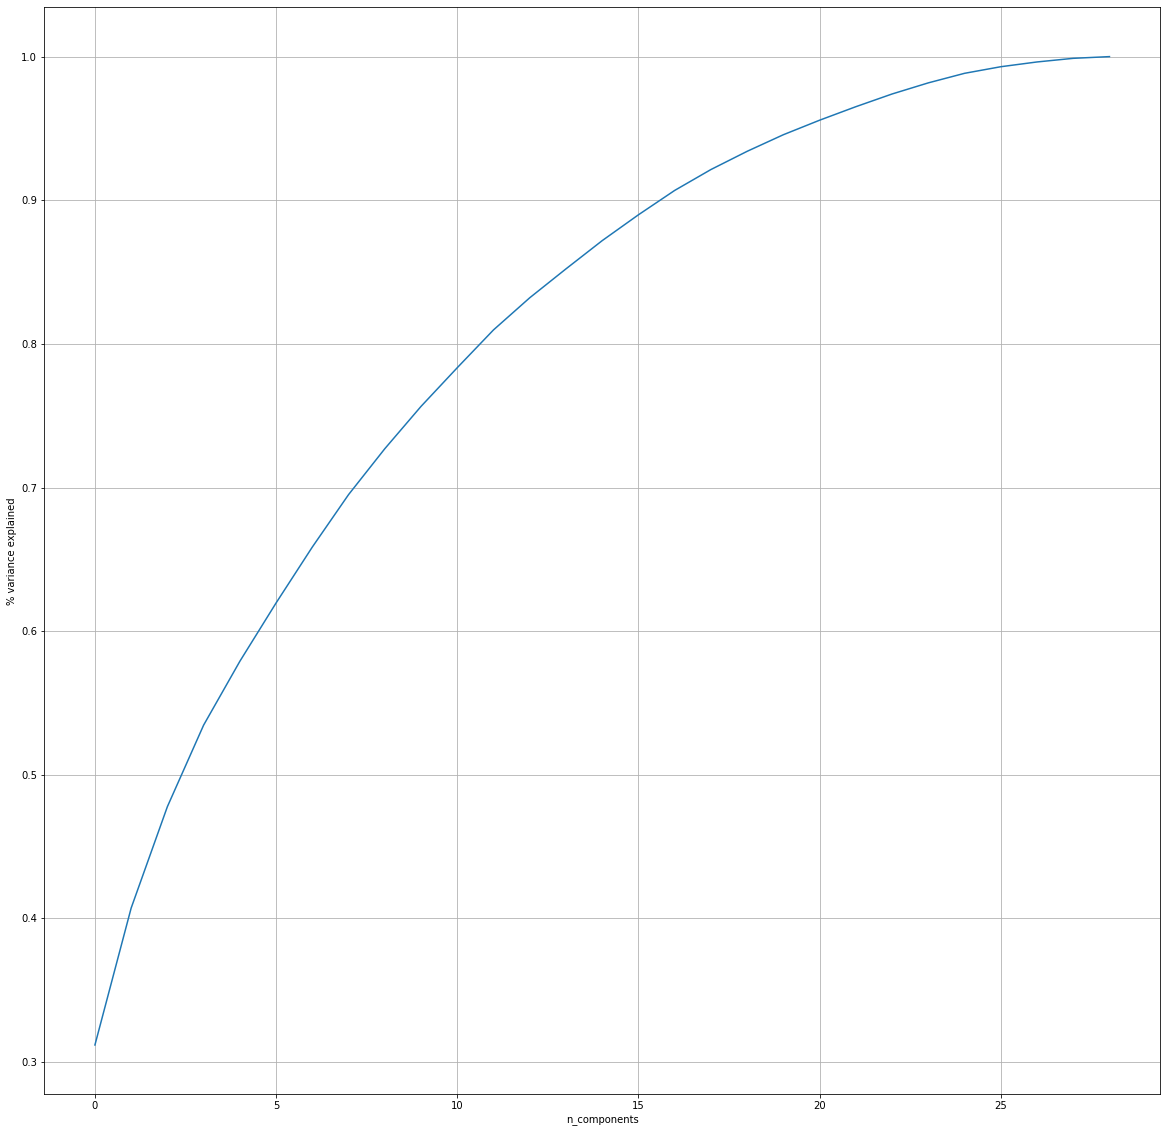

In [2711]:
from sklearn.decomposition import PCA
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [2459]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
#Include Date and R0 for later filtering
principalDf['Date']=df['Date']
principalDf['R0']=df['R0']
df=principalDf

# Modelling and Results

pip install xgboost

In [309]:
#Predictions from January 2021
#df=df[pd.to_datetime(df['Date']) > pd.Timestamp(2020, 5, 1)]
date1=pd.Timestamp(2020, 12, 1)
date2=pd.Timestamp(2021, 1, 1)
#df=df[(pd.to_datetime(df['Date']) < date2)]
X_1=df[(pd.to_datetime(df['Date']) <= date1)]

X_2=df[(pd.to_datetime(df['Date']) > date1)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['R0']
y_test=X_2['R0']

## XGBoost Regressor 

### Modelling with GridSearchCV 

In [370]:
#Mape custom scoring function
def mse(pred, train): 
    return mean_squared_error(train, pred)

In [371]:
# A parameter grid for XGBoost
params = {'max_depth': [2,3,4], 'n_estimators':[15,16,17]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(num_boost_rounds=1000) 

grid = GridSearchCV(xgb, params, verbose=1, n_jobs=-1, scoring=make_scorer(mse))

In [372]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[18:10:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 208 ms, sys: 11.5 ms, total: 219 ms
Wall time: 676 ms


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.6s finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_boost_rounds=1000,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                           

In [373]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=16, n_jobs=0, num_boost_rounds=1000,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [374]:
y_pred=grid.best_estimator_.predict(X_test)
y_pred_train=grid.best_estimator_.predict(X_train)

### XGB Evaluation

#### Test Set

In [375]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.33257751629009474
mse score is 0.21742372428294912
rmse score is 0.46628716933124925
r2 score is -0.20834531853094962
mape score is 57.34394808992439


#### Train Set

In [376]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.2780257191042265
mse score is 0.1678114460909418
rmse score is 0.4096479538468877
r2 score is 0.6774962398830763
mape score is 63.042369571821986


In [377]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval.head()

,Actual,Predicted,Difference
82,1.019676,0.998957,0.020718
83,0.918754,0.821356,0.097398
84,0.679993,0.790593,0.110600
85,0.617990,0.821356,0.203366
86,0.679088,1.004635,0.325547


## Results View

#### Predicted vs Actual R0 Distribution

Text(0.5, 1.0, 'R0 Actuals')

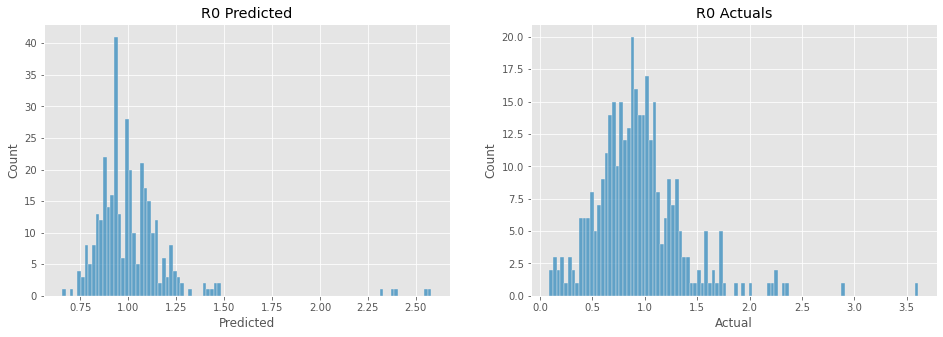

In [378]:
fig, axes =plt.subplots(1,2,figsize=(16,5))

sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes[0]);
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes[1]);
axes[0].set_title('R0 Predicted')
axes[1].set_title('R0 Actuals')

#### Difference Histogram 

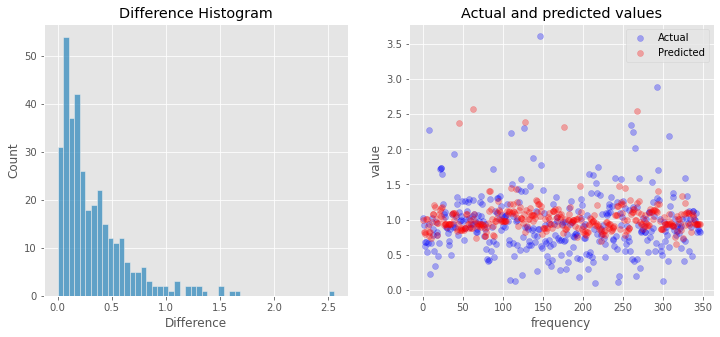

In [379]:
# plot difference hist
f, axes = plt.subplots(1,2, figsize=(12,5))

sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes[0]);
axes[0].set_title('Difference Histogram')

axes[1].scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
axes[1].scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)
plt.title('Actual and predicted values')
plt.xlabel('frequency')
plt.ylabel('value')
plt.legend()
plt.show()

#### Actual vs Predicted

Text(0.5, 1.0, 'Train Set')

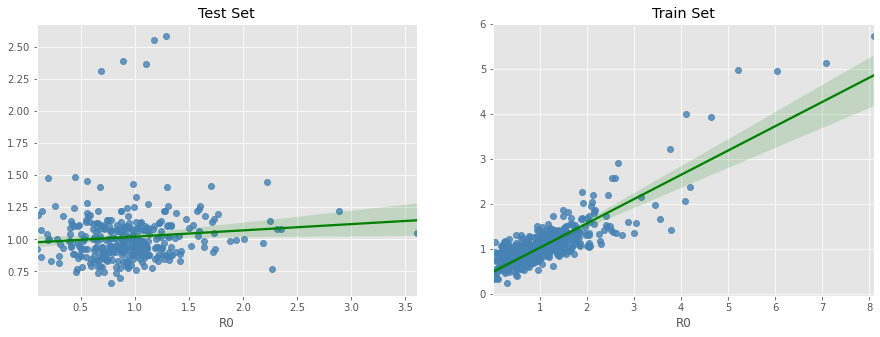

In [380]:
_, axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(y_test,y_pred,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[0]) \
            .set_title('Actual vs Predicted')
sns.regplot(y_train,y_pred_train,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[1]) \
            .set_title('Actual vs Predicted')
axes[0].set_title('Test Set')
axes[1].set_title('Train Set')

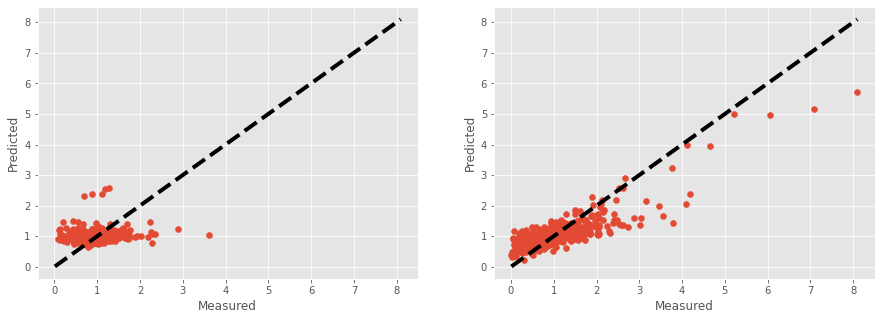

In [381]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(y_test, y_pred)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
axes[0].set_title('Train Set')
ax[0].set_xlabel('Measured')
ax[0].set_ylabel('Predicted')

ax[1].scatter(y_train, y_pred_train)
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax[1].set_xlabel('Measured')
ax[1].set_ylabel('Predicted')
axes[1].set_title('Test Set')

plt.show()

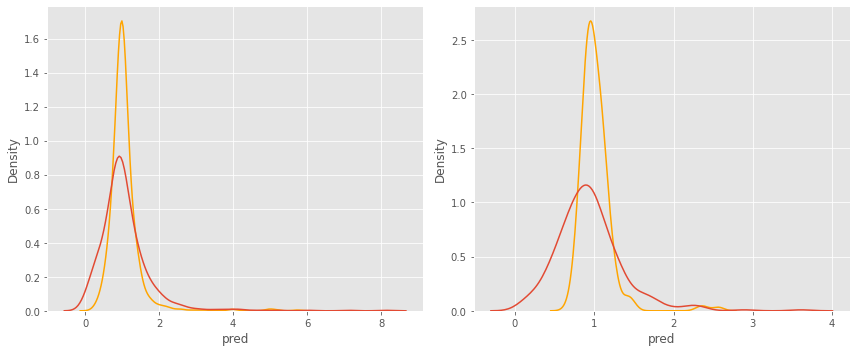

In [382]:
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [383]:
res_df_test

,pred,test,dif,dif_abs,dif%
82,0.998957,1.019676,-0.02,0.02,-2.03
83,0.821356,0.918754,-0.10,0.10,-10.60
84,0.790593,0.679993,0.11,0.11,16.26
85,0.821356,0.617990,0.20,0.20,32.91
86,1.004635,0.679088,0.33,0.33,47.94
...,...,...,...,...,...
2037,0.941851,0.821006,0.12,0.12,14.72
2038,0.941851,0.922972,0.02,0.02,2.05
2039,0.941851,0.870835,0.07,0.07,8.16
2040,0.941851,0.830681,0.11,0.11,13.38


## Feature importance 

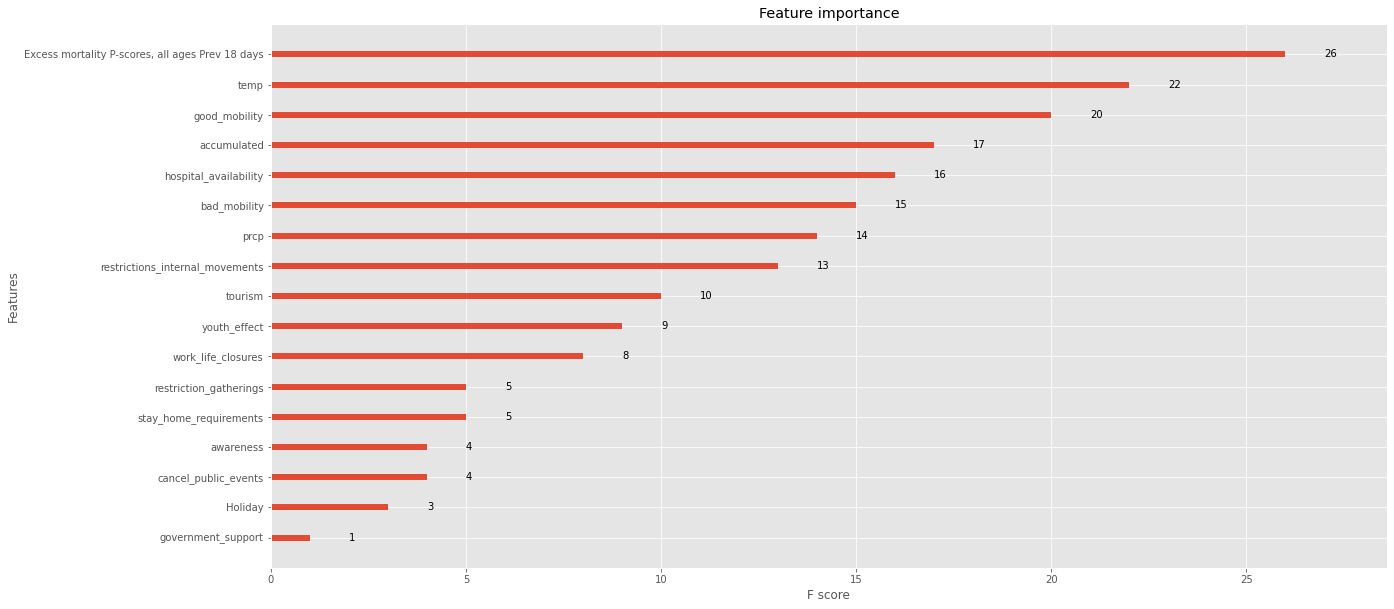

In [384]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

## Light GBM

### Modelling 

In [2664]:
params = {
    'metric': ['mape'],
    "max_depth":[6,7,8] , 
    "n_estimators":[150,180]
}

# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid = GridSearchCV(lgbm, params)

In [2665]:
%%time
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
grid.fit(X_train, y_train)

CPU times: user 17.6 s, sys: 263 ms, total: 17.9 s
Wall time: 4.65 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_depth': [6, 7, 8], 'metric': ['mape'],
                         'n_estimators': [150, 180]})

In [2666]:
grid.best_estimator_

LGBMRegressor(max_depth=7, metric='mape', n_estimators=150)

In [2667]:
y_pred = grid.best_estimator_.predict(X_test)
y_pred_train = grid.best_estimator_.predict(X_train)

### Evaluation

#### Test Set

In [2668]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse':rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.31505299876903853
mse score is 0.21833632343757836
rmse score is 0.46726472522284235
r2 score is -0.21386551075727978
mape score is 57.55235384318651


#### Train Set

In [2669]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.19051320870971447
mse score is 0.07226602091898833
rmse score is 0.26882340098843394
r2 score is 0.8255707316943995
mape score is 41.0684036096002


In [2670]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
40,0.728132,0.834789,0.106657
41,1.253247,0.567547,0.685700
42,0.559585,0.692089,0.132503
85,1.019676,1.017709,0.001966
86,0.918754,0.811691,0.107064
...,...,...,...
1992,1.512690,0.833268,0.679423
2032,1.122780,1.027712,0.095067
2033,1.129059,0.955659,0.173400
2034,1.014012,0.981639,0.032373


## Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

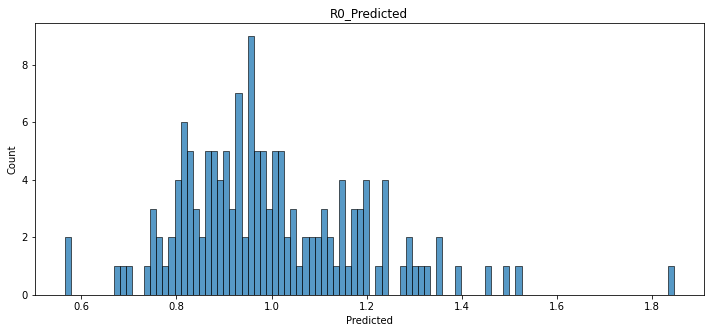

In [2671]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

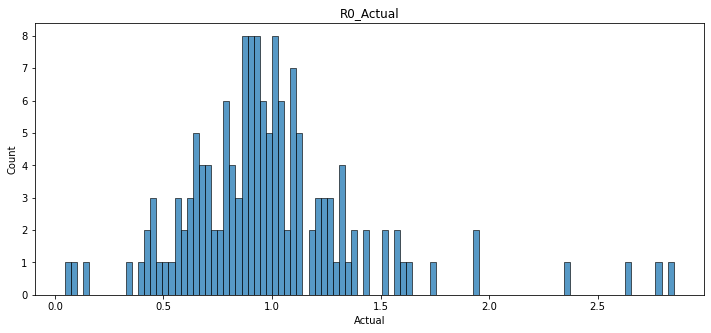

In [2672]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

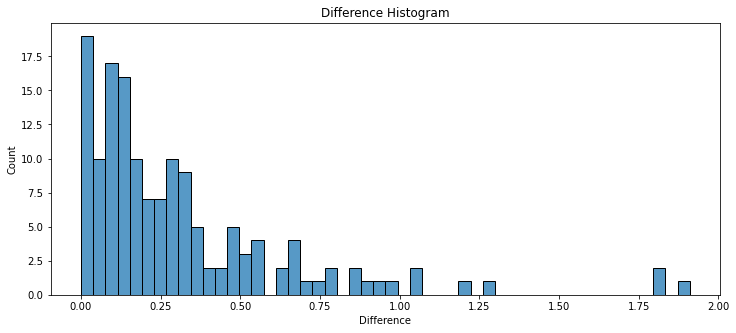

In [2673]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

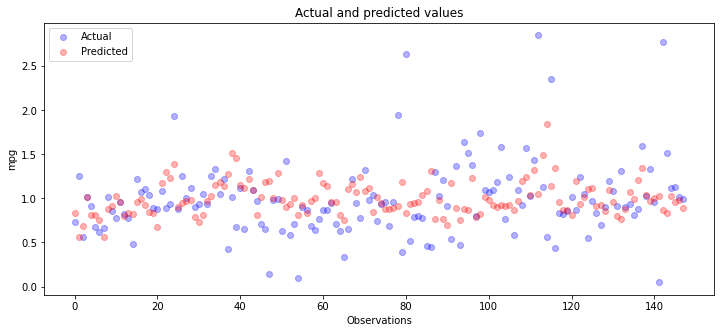

In [2674]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

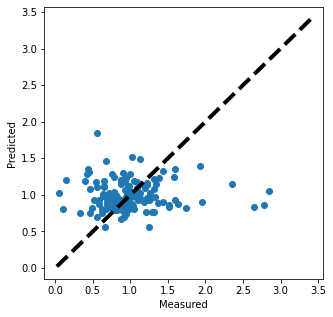

In [2675]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

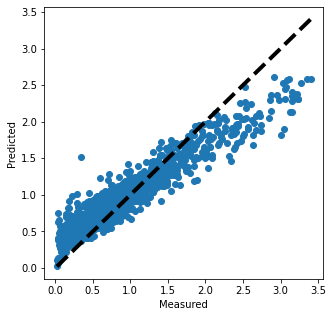

In [2676]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

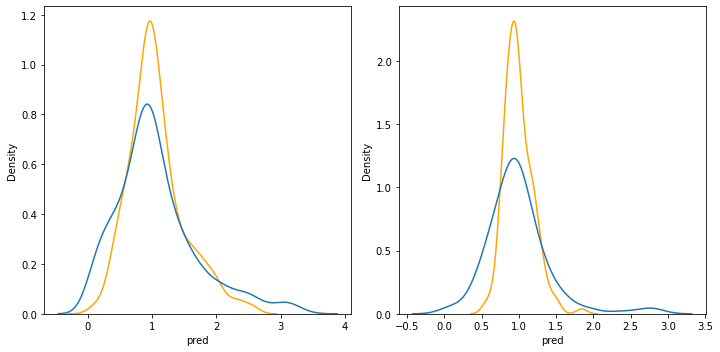

In [2677]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [2678]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1991,0.864265,2.774648,-1.91,1.91,-68.85
1118,0.832317,2.642857,-1.81,1.81,-68.51
1579,1.052594,2.850746,-1.80,1.80,-63.08
41,0.567547,1.253247,-0.69,0.69,-54.71
1116,0.908775,1.951289,-1.04,1.04,-53.43
...,...,...,...,...,...
1633,1.348551,0.436170,0.91,0.91,209.18
1631,1.845122,0.557592,1.29,1.29,230.91
768,0.806618,0.097015,0.71,0.71,731.44
662,1.200141,0.140156,1.06,1.06,756.29


In [2679]:
np.abs(res_df_test[res_df_test['test']>0.1]['dif%']).mean()

38.988287671232875

In [2680]:
res_df_test.sort_values('dif_abs')

,pred,test,dif,dif_abs,dif%
85,1.017709,1.019676,-0.00,0.00,-0.19
608,1.091364,1.093493,-0.00,0.00,-0.19
194,0.959840,0.960303,-0.00,0.00,-0.05
1065,0.950571,0.940351,0.01,0.01,1.09
1369,0.791474,0.800494,-0.01,0.01,-1.13
...,...,...,...,...,...
1632,1.143088,2.353678,-1.21,1.21,-51.43
1631,1.845122,0.557592,1.29,1.29,230.91
1579,1.052594,2.850746,-1.80,1.80,-63.08
1118,0.832317,2.642857,-1.81,1.81,-68.51


In [2681]:
res_df_test['pred'].describe()

count    148.000000
mean       0.997030
std        0.191317
min        0.566083
25%        0.872104
50%        0.964435
75%        1.113188
max        1.845122
Name: pred, dtype: float64

In [2682]:
res_df_test['test'].describe()

count    148.000000
mean       0.991198
std        0.425549
min        0.046632
25%        0.765624
50%        0.941991
75%        1.122607
max        2.850746
Name: test, dtype: float64

## CatBoost Regressor 

### Modelling 

In [2591]:
ctbst = CatBoostRegressor(learning_rate=0.02, eval_metric='MAPE',depth=8, has_time=True)

ctbst.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)

0:	learn: 0.3778351	test: 0.2386707	best: 0.2386707 (0)	total: 16.1ms	remaining: 16.1s
1:	learn: 0.3770795	test: 0.2382594	best: 0.2382594 (1)	total: 26.9ms	remaining: 13.4s
2:	learn: 0.3762589	test: 0.2385038	best: 0.2382594 (1)	total: 37.5ms	remaining: 12.5s
3:	learn: 0.3755394	test: 0.2381188	best: 0.2381188 (3)	total: 47.8ms	remaining: 11.9s
4:	learn: 0.3747434	test: 0.2377550	best: 0.2377550 (4)	total: 58.6ms	remaining: 11.7s
5:	learn: 0.3738215	test: 0.2373118	best: 0.2373118 (5)	total: 71.4ms	remaining: 11.8s
6:	learn: 0.3730714	test: 0.2379233	best: 0.2373118 (5)	total: 83.3ms	remaining: 11.8s
7:	learn: 0.3723007	test: 0.2381891	best: 0.2373118 (5)	total: 94.7ms	remaining: 11.7s
8:	learn: 0.3714573	test: 0.2379947	best: 0.2373118 (5)	total: 105ms	remaining: 11.5s
9:	learn: 0.3707068	test: 0.2375894	best: 0.2373118 (5)	total: 115ms	remaining: 11.4s
10:	learn: 0.3699588	test: 0.2381028	best: 0.2373118 (5)	total: 125ms	remaining: 11.3s
11:	learn: 0.3692266	test: 0.2379285	best: 0.

102:	learn: 0.3223523	test: 0.2364385	best: 0.2342836 (30)	total: 1.22s	remaining: 10.6s
103:	learn: 0.3219683	test: 0.2364338	best: 0.2342836 (30)	total: 1.23s	remaining: 10.6s
104:	learn: 0.3214062	test: 0.2361762	best: 0.2342836 (30)	total: 1.24s	remaining: 10.5s
105:	learn: 0.3211348	test: 0.2365527	best: 0.2342836 (30)	total: 1.25s	remaining: 10.5s
106:	learn: 0.3208159	test: 0.2366243	best: 0.2342836 (30)	total: 1.26s	remaining: 10.5s
107:	learn: 0.3204249	test: 0.2367866	best: 0.2342836 (30)	total: 1.26s	remaining: 10.4s
108:	learn: 0.3202432	test: 0.2366659	best: 0.2342836 (30)	total: 1.27s	remaining: 10.4s
109:	learn: 0.3197390	test: 0.2367990	best: 0.2342836 (30)	total: 1.28s	remaining: 10.4s
110:	learn: 0.3196303	test: 0.2368301	best: 0.2342836 (30)	total: 1.29s	remaining: 10.3s
111:	learn: 0.3190822	test: 0.2367561	best: 0.2342836 (30)	total: 1.3s	remaining: 10.3s
112:	learn: 0.3186702	test: 0.2366575	best: 0.2342836 (30)	total: 1.31s	remaining: 10.3s
113:	learn: 0.3184721	

201:	learn: 0.2911138	test: 0.2421357	best: 0.2342836 (30)	total: 2.21s	remaining: 8.72s
202:	learn: 0.2909492	test: 0.2421778	best: 0.2342836 (30)	total: 2.22s	remaining: 8.71s
203:	learn: 0.2907171	test: 0.2422096	best: 0.2342836 (30)	total: 2.23s	remaining: 8.71s
204:	learn: 0.2904110	test: 0.2423833	best: 0.2342836 (30)	total: 2.24s	remaining: 8.7s
205:	learn: 0.2900287	test: 0.2422569	best: 0.2342836 (30)	total: 2.25s	remaining: 8.68s
206:	learn: 0.2898074	test: 0.2421579	best: 0.2342836 (30)	total: 2.26s	remaining: 8.65s
207:	learn: 0.2896801	test: 0.2419601	best: 0.2342836 (30)	total: 2.27s	remaining: 8.63s
208:	learn: 0.2893602	test: 0.2419218	best: 0.2342836 (30)	total: 2.27s	remaining: 8.6s
209:	learn: 0.2889599	test: 0.2418980	best: 0.2342836 (30)	total: 2.28s	remaining: 8.57s
210:	learn: 0.2886198	test: 0.2419474	best: 0.2342836 (30)	total: 2.28s	remaining: 8.54s
211:	learn: 0.2884053	test: 0.2417962	best: 0.2342836 (30)	total: 2.29s	remaining: 8.52s
212:	learn: 0.2880405	t

312:	learn: 0.2641064	test: 0.2456400	best: 0.2342836 (30)	total: 3.23s	remaining: 7.1s
313:	learn: 0.2638599	test: 0.2456096	best: 0.2342836 (30)	total: 3.25s	remaining: 7.09s
314:	learn: 0.2635286	test: 0.2457196	best: 0.2342836 (30)	total: 3.26s	remaining: 7.08s
315:	learn: 0.2633603	test: 0.2457129	best: 0.2342836 (30)	total: 3.27s	remaining: 7.07s
316:	learn: 0.2631138	test: 0.2457821	best: 0.2342836 (30)	total: 3.27s	remaining: 7.05s
317:	learn: 0.2628661	test: 0.2457072	best: 0.2342836 (30)	total: 3.28s	remaining: 7.04s
318:	learn: 0.2626807	test: 0.2458140	best: 0.2342836 (30)	total: 3.29s	remaining: 7.02s
319:	learn: 0.2625632	test: 0.2458060	best: 0.2342836 (30)	total: 3.29s	remaining: 7s
320:	learn: 0.2623518	test: 0.2457543	best: 0.2342836 (30)	total: 3.3s	remaining: 6.98s
321:	learn: 0.2621127	test: 0.2457672	best: 0.2342836 (30)	total: 3.31s	remaining: 6.96s
322:	learn: 0.2620033	test: 0.2457452	best: 0.2342836 (30)	total: 3.31s	remaining: 6.95s
323:	learn: 0.2617947	test

417:	learn: 0.2451292	test: 0.2480448	best: 0.2342836 (30)	total: 4.02s	remaining: 5.59s
418:	learn: 0.2450062	test: 0.2480204	best: 0.2342836 (30)	total: 4.03s	remaining: 5.59s
419:	learn: 0.2448702	test: 0.2480543	best: 0.2342836 (30)	total: 4.04s	remaining: 5.58s
420:	learn: 0.2446373	test: 0.2480085	best: 0.2342836 (30)	total: 4.05s	remaining: 5.57s
421:	learn: 0.2443939	test: 0.2480661	best: 0.2342836 (30)	total: 4.06s	remaining: 5.56s
422:	learn: 0.2442590	test: 0.2480972	best: 0.2342836 (30)	total: 4.07s	remaining: 5.55s
423:	learn: 0.2439279	test: 0.2481167	best: 0.2342836 (30)	total: 4.07s	remaining: 5.53s
424:	learn: 0.2437585	test: 0.2482223	best: 0.2342836 (30)	total: 4.08s	remaining: 5.52s
425:	learn: 0.2436201	test: 0.2483831	best: 0.2342836 (30)	total: 4.09s	remaining: 5.5s
426:	learn: 0.2435063	test: 0.2483842	best: 0.2342836 (30)	total: 4.09s	remaining: 5.49s
427:	learn: 0.2434232	test: 0.2483939	best: 0.2342836 (30)	total: 4.1s	remaining: 5.48s
428:	learn: 0.2433390	t

535:	learn: 0.2250302	test: 0.2497446	best: 0.2342836 (30)	total: 4.8s	remaining: 4.16s
536:	learn: 0.2248272	test: 0.2497666	best: 0.2342836 (30)	total: 4.81s	remaining: 4.15s
537:	learn: 0.2245934	test: 0.2496778	best: 0.2342836 (30)	total: 4.82s	remaining: 4.14s
538:	learn: 0.2244206	test: 0.2496462	best: 0.2342836 (30)	total: 4.83s	remaining: 4.13s
539:	learn: 0.2242569	test: 0.2494588	best: 0.2342836 (30)	total: 4.84s	remaining: 4.13s
540:	learn: 0.2241527	test: 0.2494339	best: 0.2342836 (30)	total: 4.85s	remaining: 4.12s
541:	learn: 0.2240810	test: 0.2493720	best: 0.2342836 (30)	total: 4.86s	remaining: 4.11s
542:	learn: 0.2238209	test: 0.2493896	best: 0.2342836 (30)	total: 4.86s	remaining: 4.09s
543:	learn: 0.2236879	test: 0.2494275	best: 0.2342836 (30)	total: 4.87s	remaining: 4.08s
544:	learn: 0.2234693	test: 0.2493400	best: 0.2342836 (30)	total: 4.88s	remaining: 4.07s
545:	learn: 0.2233560	test: 0.2492765	best: 0.2342836 (30)	total: 4.88s	remaining: 4.06s
546:	learn: 0.2230564	

635:	learn: 0.2092497	test: 0.2509048	best: 0.2342836 (30)	total: 5.57s	remaining: 3.19s
636:	learn: 0.2091186	test: 0.2508402	best: 0.2342836 (30)	total: 5.58s	remaining: 3.18s
637:	learn: 0.2089463	test: 0.2508487	best: 0.2342836 (30)	total: 5.59s	remaining: 3.17s
638:	learn: 0.2088433	test: 0.2508553	best: 0.2342836 (30)	total: 5.6s	remaining: 3.17s
639:	learn: 0.2086661	test: 0.2508066	best: 0.2342836 (30)	total: 5.61s	remaining: 3.16s
640:	learn: 0.2084342	test: 0.2508199	best: 0.2342836 (30)	total: 5.62s	remaining: 3.15s
641:	learn: 0.2082505	test: 0.2508508	best: 0.2342836 (30)	total: 5.63s	remaining: 3.14s
642:	learn: 0.2081744	test: 0.2508027	best: 0.2342836 (30)	total: 5.63s	remaining: 3.13s
643:	learn: 0.2080090	test: 0.2507524	best: 0.2342836 (30)	total: 5.64s	remaining: 3.12s
644:	learn: 0.2076924	test: 0.2507377	best: 0.2342836 (30)	total: 5.64s	remaining: 3.11s
645:	learn: 0.2075140	test: 0.2506785	best: 0.2342836 (30)	total: 5.65s	remaining: 3.1s
646:	learn: 0.2074747	t

732:	learn: 0.1958772	test: 0.2520296	best: 0.2342836 (30)	total: 6.35s	remaining: 2.31s
733:	learn: 0.1956779	test: 0.2520115	best: 0.2342836 (30)	total: 6.36s	remaining: 2.3s
734:	learn: 0.1955385	test: 0.2521459	best: 0.2342836 (30)	total: 6.37s	remaining: 2.3s
735:	learn: 0.1954735	test: 0.2522158	best: 0.2342836 (30)	total: 6.38s	remaining: 2.29s
736:	learn: 0.1954077	test: 0.2522286	best: 0.2342836 (30)	total: 6.39s	remaining: 2.28s
737:	learn: 0.1952635	test: 0.2522042	best: 0.2342836 (30)	total: 6.4s	remaining: 2.27s
738:	learn: 0.1950133	test: 0.2522484	best: 0.2342836 (30)	total: 6.4s	remaining: 2.26s
739:	learn: 0.1948387	test: 0.2522581	best: 0.2342836 (30)	total: 6.41s	remaining: 2.25s
740:	learn: 0.1947215	test: 0.2522882	best: 0.2342836 (30)	total: 6.42s	remaining: 2.24s
741:	learn: 0.1946112	test: 0.2520744	best: 0.2342836 (30)	total: 6.42s	remaining: 2.23s
742:	learn: 0.1944326	test: 0.2521906	best: 0.2342836 (30)	total: 6.43s	remaining: 2.22s
743:	learn: 0.1941862	tes

848:	learn: 0.1815514	test: 0.2535838	best: 0.2342836 (30)	total: 7.12s	remaining: 1.27s
849:	learn: 0.1815034	test: 0.2536112	best: 0.2342836 (30)	total: 7.13s	remaining: 1.26s
850:	learn: 0.1813808	test: 0.2537464	best: 0.2342836 (30)	total: 7.14s	remaining: 1.25s
851:	learn: 0.1811430	test: 0.2536817	best: 0.2342836 (30)	total: 7.15s	remaining: 1.24s
852:	learn: 0.1809669	test: 0.2536720	best: 0.2342836 (30)	total: 7.16s	remaining: 1.23s
853:	learn: 0.1808535	test: 0.2536561	best: 0.2342836 (30)	total: 7.17s	remaining: 1.23s
854:	learn: 0.1806601	test: 0.2537896	best: 0.2342836 (30)	total: 7.18s	remaining: 1.22s
855:	learn: 0.1805984	test: 0.2538760	best: 0.2342836 (30)	total: 7.18s	remaining: 1.21s
856:	learn: 0.1804510	test: 0.2537017	best: 0.2342836 (30)	total: 7.19s	remaining: 1.2s
857:	learn: 0.1802546	test: 0.2537282	best: 0.2342836 (30)	total: 7.2s	remaining: 1.19s
858:	learn: 0.1800183	test: 0.2537129	best: 0.2342836 (30)	total: 7.2s	remaining: 1.18s
859:	learn: 0.1798747	te

963:	learn: 0.1672302	test: 0.2567596	best: 0.2342836 (30)	total: 7.91s	remaining: 295ms
964:	learn: 0.1671124	test: 0.2567518	best: 0.2342836 (30)	total: 7.92s	remaining: 287ms
965:	learn: 0.1669146	test: 0.2568428	best: 0.2342836 (30)	total: 7.93s	remaining: 279ms
966:	learn: 0.1668924	test: 0.2568358	best: 0.2342836 (30)	total: 7.94s	remaining: 271ms
967:	learn: 0.1667279	test: 0.2569468	best: 0.2342836 (30)	total: 7.95s	remaining: 263ms
968:	learn: 0.1666246	test: 0.2569730	best: 0.2342836 (30)	total: 7.96s	remaining: 255ms
969:	learn: 0.1665527	test: 0.2570368	best: 0.2342836 (30)	total: 7.96s	remaining: 246ms
970:	learn: 0.1663748	test: 0.2569999	best: 0.2342836 (30)	total: 7.97s	remaining: 238ms
971:	learn: 0.1662634	test: 0.2569736	best: 0.2342836 (30)	total: 7.97s	remaining: 230ms
972:	learn: 0.1660635	test: 0.2570864	best: 0.2342836 (30)	total: 7.98s	remaining: 221ms
973:	learn: 0.1659547	test: 0.2571730	best: 0.2342836 (30)	total: 7.99s	remaining: 213ms
974:	learn: 0.1657396

In [2592]:
y_pred = ctbst.predict(X_test)
y_pred_train = ctbst.predict(X_train)

### Evaluation

#### Test Set

In [2593]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.2817373687920996
mse score is 0.16153781068995562
rmse score is 0.40191766655616873
r2 score is 0.022984621527634586
mape score is 53.86939158972128


#### Train Set

In [2594]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.4818523228620645
mse score is 0.4139128262684807
rmse score is 0.643360572516284
r2 score is 0.09229449701930292
mape score is 126.97794576309556


In [2595]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
35,0.524272,1.059935,0.535663
37,0.070393,1.078399,1.008006
38,1.352941,1.084572,0.268369
40,0.728132,1.079855,0.351722
41,1.253247,1.083353,0.169893
...,...,...,...
2031,1.072168,1.052478,0.019691
2032,1.122780,1.044216,0.078564
2033,1.129059,1.012930,0.116129
2034,1.014012,1.013668,0.000344


### Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

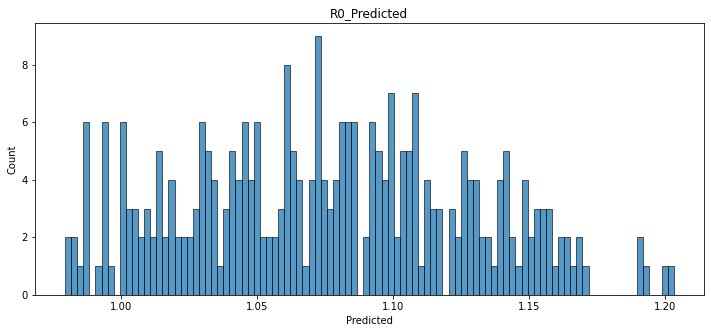

In [2596]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

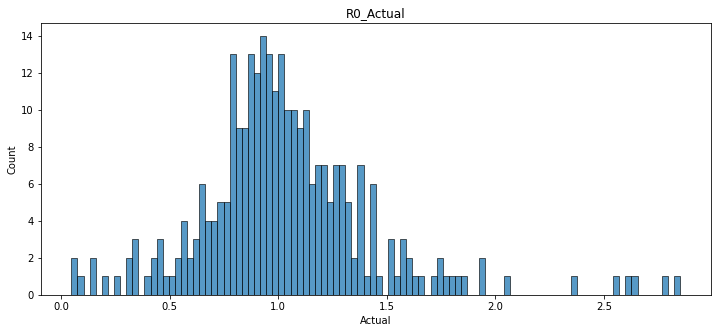

In [2597]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

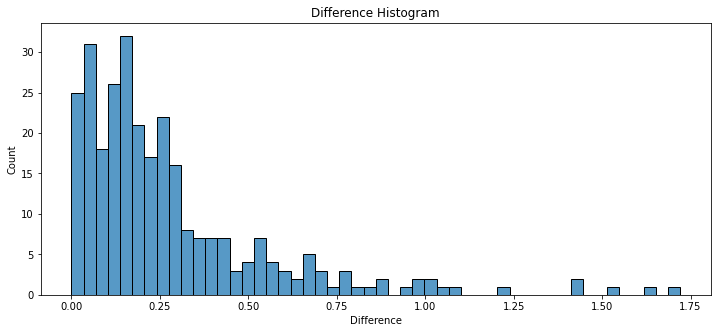

In [2598]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

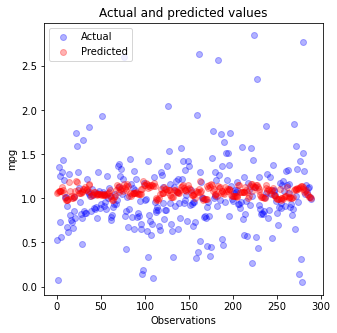

In [2599]:
_, ax = plt.subplots(figsize=(5,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

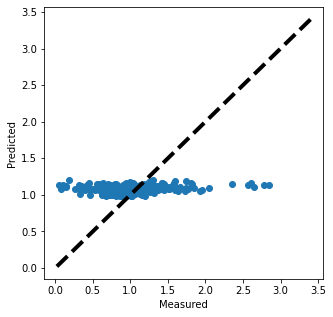

In [2600]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

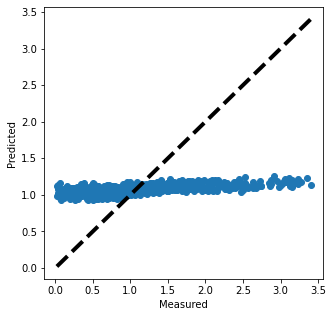

In [2601]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

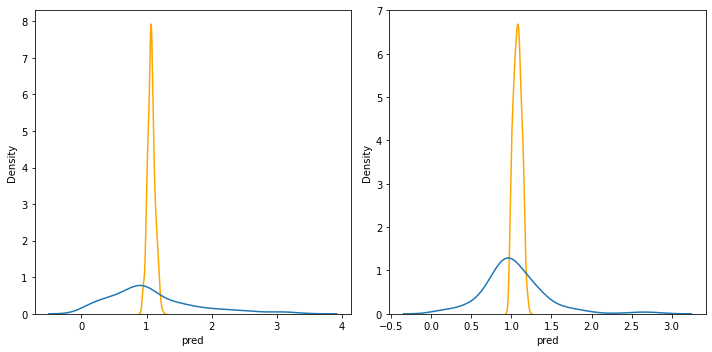

In [2602]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [2603]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1579,1.130191,2.850746,-1.72,1.72,-60.35
1991,1.133187,2.774648,-1.64,1.64,-59.16
1118,1.105473,2.642857,-1.54,1.54,-58.17
1313,1.138798,2.566578,-1.43,1.43,-55.63
547,1.164897,2.606061,-1.44,1.44,-55.30
...,...,...,...,...,...
1985,1.123258,0.147126,0.98,0.98,663.46
662,1.111528,0.140156,0.97,0.97,693.07
768,1.141312,0.097015,1.04,1.04,1076.43
37,1.078399,0.070393,1.01,1.01,1431.96


In [2604]:
df.columns

Index(['Code', 'Date', 'restrictions_internal_movements',
       'close_public_transport', 'stay_home_requirements',
       'restriction_gatherings', 'cancel_public_events', 'Holiday', 'temp',
       'prcp', 'total_vaccinations_per_100',
       'Excess mortality P-scores, all ages Prev 18 days', 'accumulated',
       'bad_mobility', 'good_mobility', 'tourism', 'awareness',
       'work_life_closures', 'government_support', 'hospital_availability',
       'youth_effect', 'R0'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

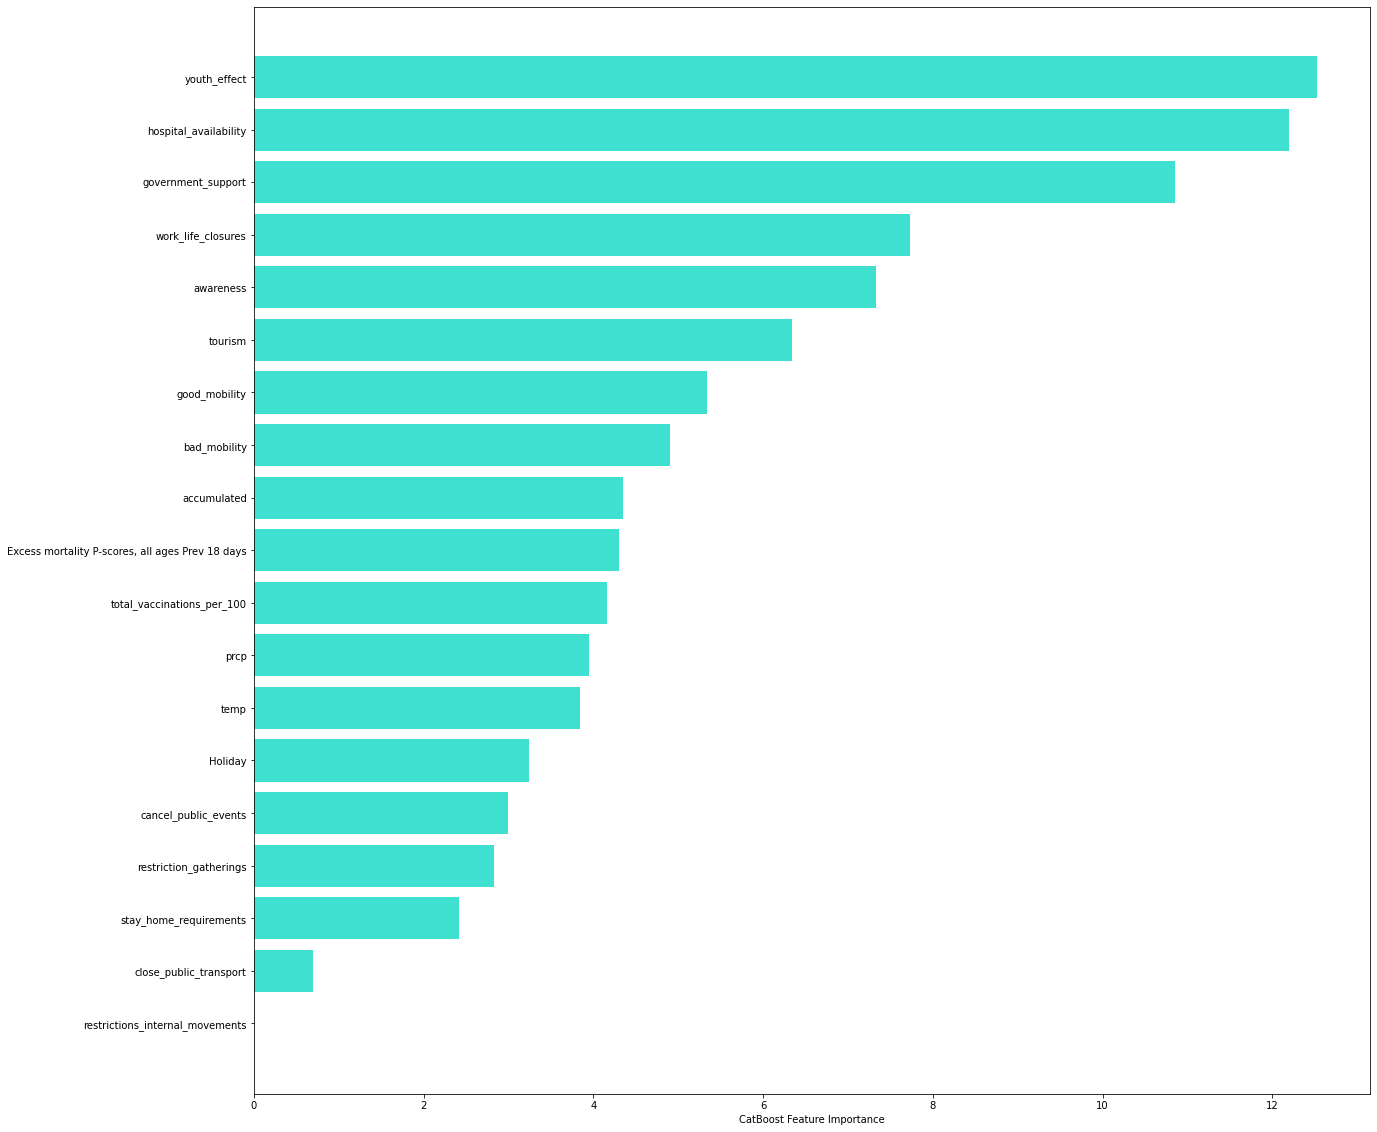

In [2605]:
sorted_feature_importance = ctbst.feature_importances_.argsort()
plt.barh(df[df.columns[2:-1]].columns, 
        ctbst.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

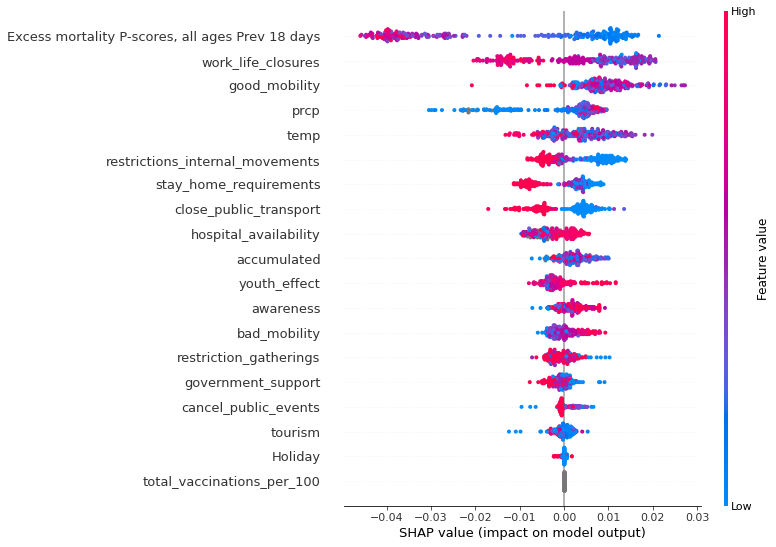

In [2607]:
explainer = shap.TreeExplainer(ctbst)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = df[df.columns[2:-1]].columns)

## Cross Validation

In [2685]:
aux=df.copy()
aux=aux.sort_values('Date')
X=aux[aux.columns[2:-1]]
y=aux[aux.columns[-1]]

In [2689]:
X

,restrictions_internal_movements,close_public_transport,stay_home_requirements,restriction_gatherings,cancel_public_events,Holiday,temp,prcp,total_vaccinations_per_100,"Excess mortality P-scores, all ages Prev 18 days",accumulated,bad_mobility,good_mobility,tourism,awareness,work_life_closures,government_support,hospital_availability,youth_effect
0,0.0,0.0,0.0,0.0,0.0,0.0,23.571259,0.106900,NaN,6.18,0.000762,3.345533,-1.279000,2.754333e+06,0.4,0.0,0.0,-28.16884,39.611115
1177,0.0,0.0,0.0,0.0,1.0,0.0,2.861111,0.081506,NaN,5.17,0.000000,-4.492200,-2.486667,5.747333e+06,0.4,0.9,0.0,-39.13128,-44.113403
152,0.0,0.0,0.0,0.0,0.0,0.0,4.898929,0.006687,NaN,0.67,0.000000,5.236733,9.625533,8.252000e+06,0.2,0.0,0.0,NaN,46.554561
403,0.0,0.0,0.0,0.0,0.0,0.0,3.851200,0.038392,NaN,-4.32,0.000000,6.135600,9.574400,3.107000e+06,0.4,0.0,0.0,6.39400,34.543429
1077,0.0,0.0,0.0,0.0,0.0,0.0,13.063492,0.002857,NaN,-2.29,0.000000,3.453333,8.661067,9.666667e+05,0.4,0.0,0.0,3.43800,23.068266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,2.0,1.0,2.0,3.0,2.0,0.0,16.490027,0.014450,NaN,61.70,0.260085,-19.453000,-8.824400,3.507900e+07,3.6,3.0,1.5,-100.15500,-139.088952
1370,0.0,0.0,0.0,4.0,2.0,0.0,-0.114379,0.000000,NaN,20.48,0.050695,-26.440829,3.804029,8.965000e+05,2.8,2.0,2.0,-93.97152,-329.981528
1320,2.0,1.0,2.0,4.0,2.0,0.0,0.859649,0.042632,NaN,45.04,0.091625,-28.330486,2.249086,3.513333e+05,2.8,1.7,1.5,NaN,-476.518761
1579,1.0,0.0,1.0,4.0,2.0,1.0,0.971677,0.072239,NaN,-4.63,0.014772,-15.285629,1.714086,2.980000e+06,2.0,1.7,1.0,6.65200,-151.022012


In [2690]:
k = 4
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    ctbst.fit(X_train, y_train)
    pred_values = ctbst.predict(X_test)
     
    acc = np.mean(np.abs((y_test - pred_values) / y_test)) * 100
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [373]:
acc_score

[14.806663546890833, 11.341388966174806, 12.132040651434133, 8.88591841205156]

In [374]:
avg_acc_score

11.791502894137833

In [375]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,transit_stations,parks,workplaces,contact_tracing,testing_policy,international_travel_controls,...,school_closures,Holiday,temp,prcp,urban_population,total_vaccinations_per_100,deaths_prev_36,accumulated,R0_prev18,R0
0,AUS,2020-03-08,1.050000,1.722333,4.977667,-2.089000,7.927667,2.0,1.0,3.0,...,0.0,0.0,23.571259,0.106900,85.904,NaN,3286.314000,0.000762,1.010084,0.985779
1,AUS,2020-03-15,0.761714,1.510143,7.697286,-0.819857,10.567714,2.0,1.0,3.0,...,0.0,0.0,22.446137,0.134501,85.904,NaN,3230.041500,0.001320,1.011711,1.000861
2,AUS,2020-03-22,1.285714,3.367429,9.346857,0.938857,10.877857,2.0,1.0,3.0,...,0.0,0.0,21.810602,0.160434,85.904,NaN,3264.430250,0.001926,1.004788,1.022493
3,AUS,2020-03-29,0.714429,8.979571,5.448857,-2.857143,8.326571,2.0,1.0,3.0,...,0.0,0.0,21.346512,0.142010,85.904,NaN,3319.452250,0.002502,0.985779,1.071272
4,AUS,2020-04-05,-0.898000,15.163286,-1.061286,-4.959143,6.959000,2.0,1.0,3.0,...,0.0,0.0,21.176835,0.054789,85.904,NaN,2680.933175,0.002969,1.000861,1.063946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.693857,-4.061286,-36.040857,-19.755143,-28.101857,1.0,3.0,3.0,...,3.0,0.0,2.886531,0.052132,82.058,0.216667,98076.329662,0.179232,1.069347,0.968071
2038,USA,2021-01-17,-22.775429,-3.979571,-38.877714,-16.653143,-42.081714,1.0,3.0,3.0,...,3.0,1.0,1.707192,0.066843,82.058,0.686667,101001.764888,0.188522,1.037051,0.949245
2039,USA,2021-01-24,-23.632714,-9.836714,-41.020286,-15.857143,-41.714143,1.0,3.0,3.0,...,3.0,1.0,2.500769,0.094533,82.058,1.415000,104454.372450,0.198645,1.028931,0.894853
2040,USA,2021-01-31,-23.979714,-11.387857,-39.571429,-22.591714,-28.999857,1.0,3.0,3.0,...,3.0,0.0,1.198128,0.038337,82.058,2.464000,104877.595312,0.206956,0.968071,0.910706
